In [1]:
# Author: Shaun Harker
# Date: 2023-07-08
# License: MIT

In [2]:
import torch
from languagemodels import Trainer, LanguageModel, save_version, load_version, display_layercode
from languagemodels import TextInput, TextOutput
from languagemodels import TransformerLayer
import asyncio
import time
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
n_vocab_in = 256
n_vocab_out = 256
d_embd = 32
d_model = 1024
n_heads = 32
d_k = 32
d_v = 32
d_hidden = 4096
n_layers = 16
bos = 0
lr = 2e-4
checkpointing = False

input_class = TextInput
input_config = {'n_vocab_in': n_vocab_in,
                'd_model': d_model,
                'bos': bos,
               }

output_class = TextOutput
output_config = {'n_vocab_out': n_vocab_out,
                 'd_model': d_model,
                }


layer_class = TransformerLayer
layer_config = {'d_model': d_model, 
                'n_heads': n_heads,
                'd_k': d_k,
                'd_v': d_v,
                'n_heads': n_heads,
                'd_hidden': d_hidden,
                'init_scale': 0.0,
                'sdp': True}

path = f'/data/models/nonstandard.pt'
prefix = '/data/thepile/'
print(path)

/data/models/nonstandard.pt


In [4]:
try:
    trainer = load_version(path=path, prefix=prefix)
except:
    print("Creating new model...")
    model = LanguageModel(
        n_vocab_in=256,
        n_vocab_out=256,
        bos=0,
        d_model=d_model,
        n_layers=n_layers,
        input_class=input_class,
        input_config=input_config,
        output_class=output_class,
        output_config=output_config,
        layer_class=layer_class,
        layer_config=layer_config,
        checkpointing=checkpointing)
    trainer = Trainer(model=model, example_length=1024, prefix=prefix)
    print("New model created.")

In [5]:
trainer.model

LanguageModel(
  (text_input): TextInput()
  (layers): ModuleList(
    (0-15): 16 x TransformerLayer(
      (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (linear): Linear(in_features=1024, out_features=1024, bias=False)
      (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (ff1): Linear(in_features=1024, out_features=4096, bias=True)
      (nonlinearity): GELU(approximate='none')
      (ff2): Linear(in_features=4096, out_features=1024, bias=False)
      (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (text_output): TextOutput()
)

In [6]:
sum(p.numel() for p in trainer.model.parameters())

201506816

In [7]:
trainer.config['batch_size'] = 8
trainer.config['batch_multiplier'] = 1
trainer.config['example_length'] = 1024

In [8]:
async def training_loop(trainer, warm_up=1000, lr=2e-4):
    t0 = time.time()    
    n = 0
    rates = [1 - 1/(2**k) for k in range(20)]
    trainer.n = 0
    trainer.t0 = time.time()
    trainer.rates = rates
    while True:
        trainer.update_lr(lr * min(1, (time.time()-t0)/warm_up))
        t, batch, losses = trainer.train()
        loss_by_layer = np.mean(losses,axis=(1,2))
        if trainer.n == 0:
            trainer.loss_by_layer_emas = np.stack([loss_by_layer for _ in range(len(rates))])
            trainer.time_emas = [t for _ in range(len(rates))]
        else:
            for idx, rate in enumerate(rates):
                trainer.loss_by_layer_emas[idx] = rate * trainer.loss_by_layer_emas[idx] + (1 - rate) * loss_by_layer
                trainer.time_emas[idx] = rate * trainer.time_emas[idx] + (1-rate)*t
        trainer.n += 1

        await asyncio.sleep(1e-4)
try:
    training_task.cancel()
except:
    print("No task to cancel.")

No task to cancel.


In [9]:
training_task = asyncio.create_task(training_loop(trainer))

In [10]:
training_task.print_stack()

Stack for <Task pending name='Task-4' coro=<training_loop() running at /tmp/ipykernel_79468/847318189.py:21> wait_for=<Future finished result=None>> (most recent call last):


  File "/tmp/ipykernel_79468/847318189.py", line 21, in training_loop
    await asyncio.sleep(1e-4)


In [ ]:
# training_task.cancel()

In [11]:
trainer.config

{'example_length': 1024,
 'batch_size': 8,
 'lr': 1e-06,
 'betas': (0.9, 0.999),
 'weight_decay': 0.001,
 'batch_multiplier': 1}

In [12]:
n = trainer.n
t = time.time() - trainer.t0
rate = n/t
n / t, n, t

(1.3605929601392026, 7, 5.144815683364868)

In [13]:
n_params = sum(p.numel() for p in trainer.model.parameters())
n_params

201506816

In [38]:
display_layercode(trainer.model.input_classcode)

In [39]:
display_layercode(trainer.model.output_classcode)

In [40]:
display_layercode(trainer.model.layer_classcode)

## generative testing

In [32]:
prompt = """In a shocking finding, scientists discovered a herd of unicorns living in a
remote, previously unexplored valley in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English."""

In [37]:
autocomplete_task = asyncio.create_task(
    trainer.model.display_autocomplete(prompt=prompt, temp=0.6, output_layer=-1, n_generate=2000, burst=32))

In [ ]:
autocomplete_task

In [36]:
autocomplete_task.cancel()

True

## loss metric


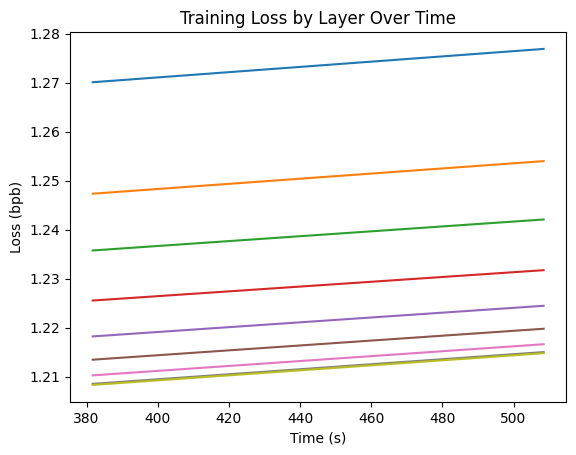

In [45]:

rf = math.floor(math.log2(trainer.n))
r0 = max(0, min(rf-2, 13))

X = np.array(trainer.time_emas[r0:rf]) - trainer.t0
Y = np.stack(trainer.loss_by_layer_emas[r0:rf])

# Create a figure and axis
fig, ax = plt.subplots()

labels = ['Layer {}'.format(i) for i in range(trainer.model.n_layers+1)]

for idx in range(8, trainer.model.n_layers+1):
    y_data = Y[:, idx]
    # Plotting data for each layer
    ax.plot(X, y_data, label=labels[idx])

# Labeling the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Loss (bpb)')

# Setting the title
ax.set_title('Training Loss by Layer Over Time')

# Adding a legend
#ax.legend()

# Displaying the plot
plt.show()

In [28]:
time.time() - trainer.t0

71.59844255447388

In [29]:
trainer.n

105

In [44]:
# should start being sensible for time.time() - trainer.t0 > 36000  (or earlier)
import math
rate_idx = min(14, math.floor(math.log2(trainer.n))-1)
for idx in range(trainer.model.n_layers+1):
    L0 = trainer.loss_by_layer_emas[rate_idx][idx]
    L1 = trainer.loss_by_layer_emas[rate_idx+1][idx]
    T0 = trainer.time_emas[rate_idx]
    T1 = trainer.time_emas[rate_idx+1]
    print(f"Layer = {idx}, L = {L0} bpb, -dL/dt = {int(-(L0-L1)/(T0-T1)*3600*24*1000)/1000} bpb per day")

Layer = 0, L = 8.0 bpb, -dL/dt = 0.0 bpb per day
Layer = 1, L = 3.6326818466186523 bpb, -dL/dt = -11.464 bpb per day
Layer = 2, L = 2.0462656021118164 bpb, -dL/dt = -20.587 bpb per day
Layer = 3, L = 1.5674024820327759 bpb, -dL/dt = -6.877 bpb per day
Layer = 4, L = 1.4442989826202393 bpb, -dL/dt = -7.16 bpb per day
Layer = 5, L = 1.3979315757751465 bpb, -dL/dt = -8.152 bpb per day
Layer = 6, L = 1.3426779508590698 bpb, -dL/dt = -7.648 bpb per day
Layer = 7, L = 1.2871968746185303 bpb, -dL/dt = -8.133 bpb per day
Layer = 8, L = 1.266863465309143 bpb, -dL/dt = -8.598 bpb per day
Layer = 9, L = 1.244120478630066 bpb, -dL/dt = -8.198 bpb per day
Layer = 10, L = 1.2325421571731567 bpb, -dL/dt = -7.641 bpb per day
Layer = 11, L = 1.2223180532455444 bpb, -dL/dt = -7.413 bpb per day
Layer = 12, L = 1.214998722076416 bpb, -dL/dt = -7.533 bpb per day
Layer = 13, L = 1.2102653980255127 bpb, -dL/dt = -7.628 bpb per day
Layer = 14, L = 1.2070585489273071 bpb, -dL/dt = -7.685 bpb per day
Layer = 15

## save

In [ ]:
print(path)
save_version(trainer, path)

## parameter count, compute estimate

In [43]:
n_ctx = 1024
d_model = 1024
d_hidden = 4096
n_layers = 16
n_vocab_in = 256
n_vocab_out = 256
batch_size = 8
compute_est = batch_size*4*n_layers*(
    3*n_ctx*(d_model**2 + d_model) + # k,q,v proj
    d_model * n_ctx ** 2 + # attention QKT
    n_ctx ** 2 + # softmax ... missing up front constant
    n_ctx**2 * d_model + # softmax(QKT) * V
    n_ctx*(d_model**2 + 2*d_model) + # linear + ln1
    n_ctx*(d_model*d_hidden + d_hidden) + # ff1
    n_ctx*(d_hidden*d_model + 2*d_model) + # ff2 + ln2
    2*n_ctx*d_model + # adding residuals
    n_ctx*d_hidden + # nonlinearity ... missing up front constant
    d_model*n_ctx*n_vocab_out) # read_head
n_param_est = (n_layers*(3*(d_model**2 + d_model) + 
    (d_model**2 + d_model) +
    d_model * d_hidden + d_hidden +
    d_hidden * d_model + d_model +
    2 * d_model) + # ln scalings
    (n_layers+1)*(d_model*n_vocab_out + n_vocab_out) + n_vocab_in*d_embd)
print(f"Performance: {int(100*rate * compute_est / 1E12)/100} TF")

Performance: 10.67 TF


In [42]:
N = sum(p.numel() for p in trainer.model.parameters())
print(f"There are {N} parameters and {n_layers} layers.")

There are 201506816 parameters and 16 layers.


# some entropy estimates


In [41]:
# here are some entropy estimates for Pile n-grams (probably increasingly underestimating for larger n)
lower = [4.99, 8.97, 12.21, 14.9, 17.11, 19.074, 20.853, 22.475, 23.959, 25.316, 26.556, 27.682, 28.69]
lowermargin = [int(100*(b-a))/100.0 for (a,b) in zip(lower[:-1], lower[1:])]
bpb_by_pos = [lower[0]] + lowermargin
print(list(enumerate(bpb_by_pos)))

[(0, 4.99), (1, 3.98), (2, 3.24), (3, 2.68), (4, 2.2), (5, 1.96), (6, 1.77), (7, 1.62), (8, 1.48), (9, 1.35), (10, 1.24), (11, 1.12), (12, 1.0)]
